<a href="https://colab.research.google.com/github/MUHAMMADALYAN/Sequences-Time-Series-and-Prediction/blob/master/Using_Single_layer_NN_for_predicting_Time_Series_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.2.0


In [0]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

# In this case we take a window size data(=month ,year) for training and next value as label throughout training data as it is not traditional datsets

In [0]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)# =1 for label
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))# converting data window into features and next to  labels
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [0]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(dataset)
l0 = tf.keras.layers.Dense(1, input_shape=[window_size]) # it is enough for linear regression
model = tf.keras.models.Sequential([l0])


model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9)) 
model.fit(dataset,epochs=100,verbose=0)#training with 20 features = window size and next as label

print("Layer weights {}".format(l0.get_weights())) # 20 weights for each 20 features


<PrefetchDataset shapes: ((None, None), (None,)), types: (tf.float32, tf.float32)>
Layer weights [array([[ 0.02175523],
       [-0.00689684],
       [-0.05907915],
       [-0.00718906],
       [ 0.06017814],
       [-0.01457362],
       [ 0.02046605],
       [-0.01902206],
       [-0.05354849],
       [ 0.12374824],
       [-0.03740293],
       [-0.07226618],
       [-0.04059113],
       [ 0.15318942],
       [-0.02919237],
       [ 0.03617898],
       [-0.00405675],
       [ 0.154577  ],
       [ 0.37781525],
       [ 0.3840849 ]], dtype=float32), array([0.01760604], dtype=float32)]


#Predicting

###It will take ach window of 20 features and give us perdicted value with the help of learned weights by patter in training 
series go from(1:21) give us label,(2:22) taking one window each time in this case.

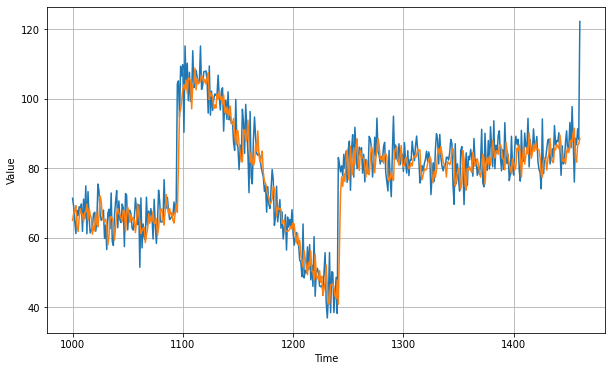

In [0]:
forecast = []
# window size will be minus from series as we want plot forecast for everypoint on time series relative to 20 points before (equal to window size)
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))#it will go from(1:21) give us label,(2:22) taking one window each time in this case.
# we  will retrain it on training and validation again it is because validation data is the closest data to the current point of time 
forecast = forecast[split_time-window_size:] # but we only forecast for validation data
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [0]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy() #

5.06095